In [1]:
import sys
from cytoemd import CytoEMD
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import umap

from sklearn.metrics import (
    roc_curve, auc
)

from collections import OrderedDict, defaultdict
from sklearn import preprocessing
from anndata import read_h5ad, AnnData

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
adata = read_h5ad("../data/human_covid19.h5ad")
marker_in_use = [
    'FSC-A',
    'FSC-H',
    'FSC-W',
    'SSC-A',
    'SSC-H',
    'SSC-W',
    'FJComp-APC-A',
    'FJComp-APC-R700-A',
    'FJComp-BB630-A',
    'FJComp-BB700-P-A',
    'FJComp-BUV395-A',
    'FJComp-BUV496-A',
    'FJComp-BUV563-A',
    'FJComp-BUV615-P-A',
    'FJComp-BUV737-A',
    'FJComp-BUV805-A',
    'FJComp-BV421-A',
    'FJComp-BV480-A',
    'FJComp-BV570-A',
    'FJComp-BV605-A',
    'FJComp-BV650-A',
    'FJComp-BV711-A',
    'FJComp-BV750-P-A',
    'FJComp-BV786-A',
    'FJComp-BYG584-A',
    'FJComp-BYG670-A',
    'FJComp-BYG790-A',
    'FJComp-FITC-A',
    'FJComp-PE-CF594-A',
    'FJComp-PE-Cy5.5-A'
]

adata.var.index = adata.var['pnn_label']
adata.var.index.name = 'index'
adata = adata[:,marker_in_use]


co_factor = 5.
# set seed for reproducibility
seed = 0

adata.X = np.arcsinh(adata.X / co_factor)

In [3]:
adata.obs.head()

,fcs_file,phenotype
1-1,./export_COVID19 samples 23_04_20_ST3_COVID19_...,HC
1-2,./export_COVID19 samples 23_04_20_ST3_COVID19_...,HC
1-3,./export_COVID19 samples 23_04_20_ST3_COVID19_...,HC
1-4,./export_COVID19 samples 23_04_20_ST3_COVID19_...,HC
1-5,./export_COVID19 samples 23_04_20_ST3_COVID19_...,HC


In [4]:
adata_list = [adata[adata.obs['fcs_file'] == sample, :] for sample in adata.obs['fcs_file'].unique()]
for x in adata_list:
    x.var.index = x.var['pnn_label'][:6].tolist() + x.var['pns_label'].tolist()[6:]
sample_meta_list = [_adata.obs[['fcs_file', 'phenotype']].iloc[0].T for _adata in adata_list]
sample_meta = pd.concat(sample_meta_list, axis=1).T

### Create the model and fit the data

In [5]:
model = CytoEMD(emd_type='UMAP', random_state=0, use_fast=True, bins=100, n_cpus=4)
embeddings = model.fit_transform(adata_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1176/1176 [02:15<00:00,  8.66it/s]


### Umap of different samples

... storing 'phenotype' as categorical


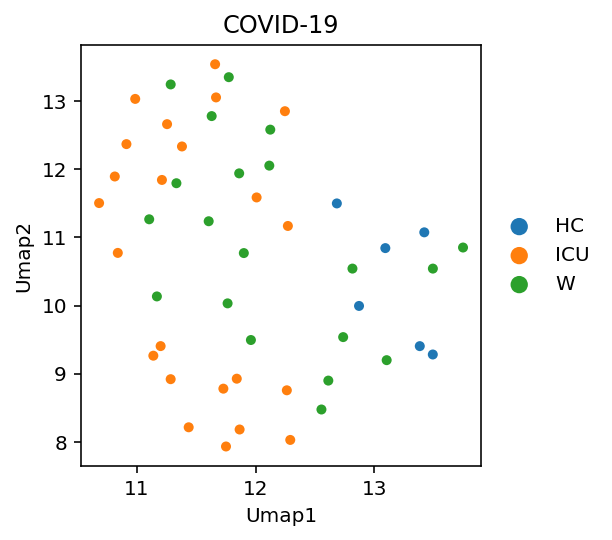

In [6]:
sample_adata = AnnData(embeddings, obs=sample_meta, var=pd.DataFrame(index=['Umap1', 'Umap2']))
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.scatter(sample_adata, x='Umap1', y='Umap2', color='phenotype', title='COVID-19', size=100)
sample_adata.write("../results/covid19_cytoemd.h5ad", compression='gzip')

In [7]:
# prepare the params of meld
sample_labels = np.array(sample_meta['phenotype'].tolist())
meld_kwargs = {'beta': 10, 'sample_normalize': True, 'knn': 4}

scaler = preprocessing.StandardScaler().fit(embeddings)
embeddings = scaler.transform(embeddings)

# predict the predicted under the phenotype (normalized to 1)
pred_prob = model.predict_prob(embeddings, sample_labels, meld_kwargs)
pred_prob.head()

Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


,HC,ICU,W
0,0.767383,0.017695,0.214922
1,0.760528,0.020583,0.218889
2,0.608684,0.103930,0.287386
3,0.761136,0.020213,0.218651
4,0.709278,0.047044,0.243678


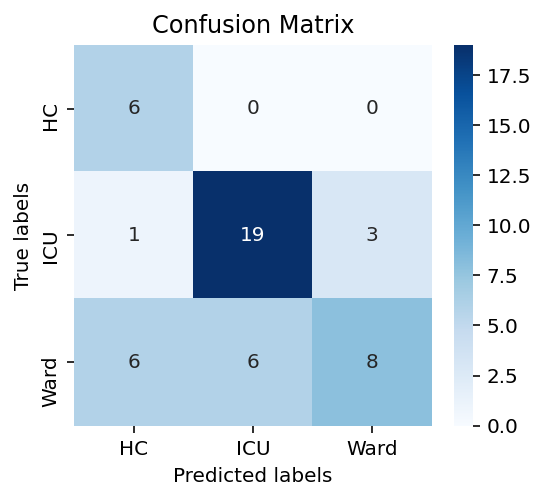

In [8]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_label = pred_prob.idxmax(axis=1).tolist()
cm = confusion_matrix(sample_labels, pred_label)

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['HC', 'ICU', 'Ward']);
ax.yaxis.set_ticklabels(['HC', 'ICU', 'Ward']);

In [9]:
# calculate the ce score for each marker
ce_score = model.rank_markers(adata_list, sample_labels, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score = OrderedDict(sorted(ce_score.items(), key=lambda x: x[1]))
# print ce_score (lower is more significant)
print(ce_score)

Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

In [10]:
### create data frame
# marker_map = pd.Series(adata.var.iloc[6:].pns_label.values, index=adata.var.iloc[6:].pnn_label).to_dict()
ce_df = defaultdict(list)
for k, v in ce_score.items():
    ce_df['Marker'].append(k)
    ce_df['Cross Entropy Score'].append(v)

ce_df = pd.DataFrame(ce_df)

In [11]:
ce_df.head()

,Marker,Cross Entropy Score
0,CD25,0.695467
1,HLA-DR,0.698320
2,IL-10,0.718044
3,CD14,0.734843
4,CD3,0.787709


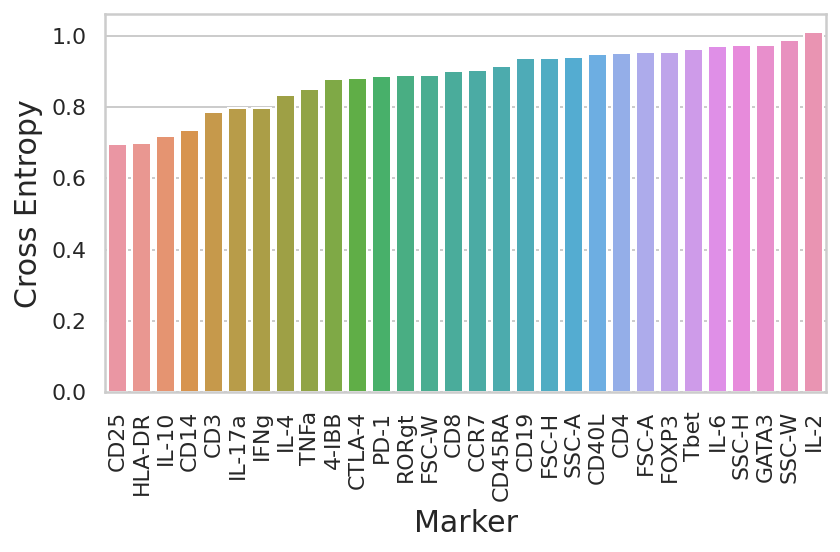

In [12]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Marker", y='Cross Entropy Score', data=ce_df)

ax.set_xlabel("Marker", fontsize=15)
ax.set_ylabel("Cross Entropy", fontsize=15)
ax.set_xticklabels(ce_df['Marker'], rotation=90)

plt.tight_layout()
plt.show()

### Rank the marker pairs using cross entropy score

In [13]:
# calculate the ce score for each marker pair
ce_score_pair = model.rank_markers(adata_list, sample_labels, eval_pair=True, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score_pair = OrderedDict(sorted(ce_score_pair.items(), key=lambda x: x[1]))

Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusi

Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples a

Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusi

Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples a

Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 49 samples and 2 features.
Calculating graph and diffusi

<AxesSubplot:>

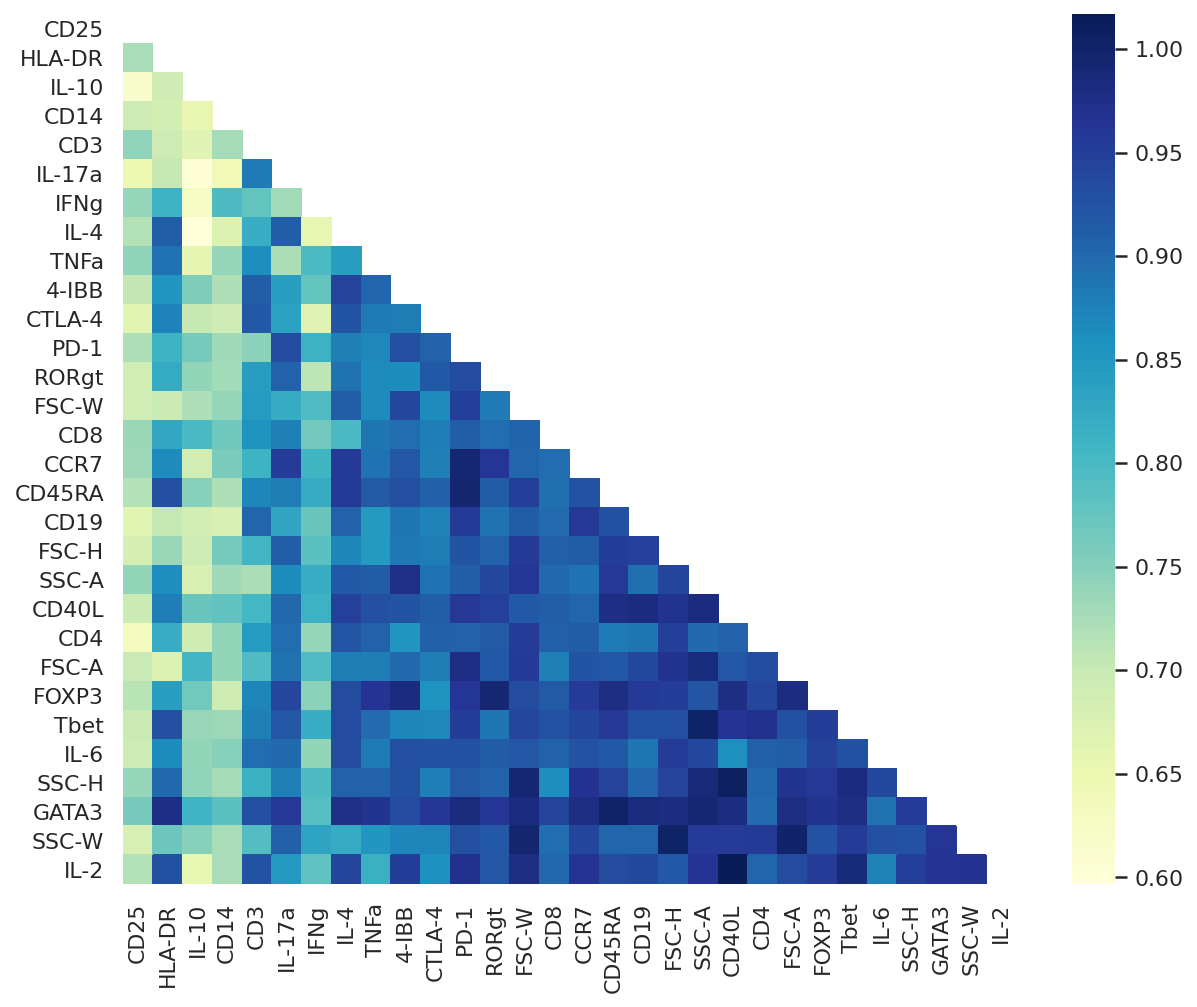

In [14]:
import seaborn as sns
from itertools import combinations

marker_list = list(ce_df['Marker'])
score_mtx = np.zeros((len(marker_list), len(marker_list)))
mask = np.zeros_like(score_mtx)
mask[np.triu_indices_from(mask)] = True

for m1, m2 in combinations(marker_list, r=2):
    i1, i2 = marker_list.index(m1), marker_list.index(m2)
    k = '-'.join([m1, m2])
    if k in ce_score_pair.keys():
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]
    else:
        k = '-'.join([m2, m1])
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(score_mtx, mask=mask, annot=False, fmt='g', ax=ax,
            cmap='YlGnBu', yticklabels = marker_list, xticklabels = marker_list)
# ax.set_title('Cross Entropy Score Matrix')